In [44]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# What does the death rate of moose need to be to have a positive trend in Northeastern Minnesotan moose population?

To make this model the following assumptions were made:

    -The birth rate of the moose remains constant (which is based on past data)
    -Death rate remains constant year to year throughout simulation
    -Moose population will not correct itself organically

The following data collected from the Minnesota DNR: https://files.dnr.state.mn.us/wildlife/moose/moosesurvey.pdf

In [45]:
population = [8160, 8840, 6860, 7890, 7840, 5700, 4900, 4230, 2760, 4350, 3450, 4020, 3710, 3030];

In [46]:
years = range(2005,2019);

We then put the data into the TimeSeries, so it is easier to work with.

In [47]:
population_series = TimeSeries(population, index = years, dtype = float)

,values
2005,8160.0
2006,8840.0
2007,6860.0
2008,7890.0
2009,7840.0
2010,5700.0
2011,4900.0
2012,4230.0
2013,2760.0
2014,4350.0


Create a fucntion to calculate the average birth rate over time.  This was calculated using the assumption of a 25% death rate.  This value is from a New York Times article: https://www.nytimes.com/2013/10/15/science/earth/something-is-killing-off-the-moose.html

In [48]:
def birth_rate(population):
    """
    Find the average birth rate over the interval data was collected.  This is based on the assumption the death rate was 25%.
    
    population: Values of moose population given by the Minnesota DNR
    
    returns: The average birth rate in the range of 2005-2018 assuming a 25% death rate
    """
    #initialize sum to zero
    sum=0
    #create a for loop to find the sum of all values, this is then used to find an average
    for i in range(13):
        birth = population[i+1]/population[i]-0.75
        sum = sum + birth
        #print(sum)
    avgbirth = sum/14
    return avgbirth

#returns the average birth rate over 2005-2018 interval

avgbirth = birth_rate(population)
print(avgbirth)

0.18782875308272756


Create a function for the line of best fit to show the trend of the moose population over time.

In [49]:
def best_fit():
    """Find line of best fit for data to show the general trend over time.
    
    returns: A TimeSeries with corresponding values that are outputs of the function
    """
    t = TimeSeries()
    #for loop is used to determine the values of the function at each corresponding x value.
    for x in (0, 2050):
        y = (-454.286*x) + 919206
        t[x] = y
    return t

Create a scatter plot of the past data by year and plot a line of best fit for the data, which shows the overall negative trend.

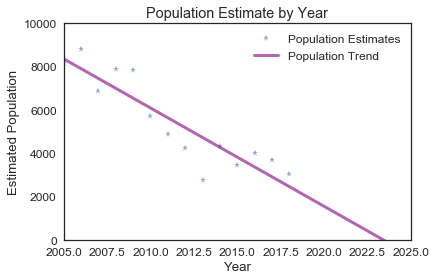

In [50]:
def population_graph(series):
    plot(series,'*', label='Population Estimates')
    plot(best_fit(), "purple", label='Population Trend')
    decorate(xlabel = 'Year',
           ylabel = 'Estimated Population',
           title = 'Population Estimate by Year')
    plt.ylim([0, 10000]);
    plt.xlim([2005, 2025]);
    
population_graph(population_series)

These are the input parameters for the simulation we will run.

In [51]:
#initialize parameters to set as a system object
time_initial = 2018;
moose = population_series[time_initial];
birth_rate = avgbirth;
duration = 15;

We create system objects to input into the update and simulation functions.  This makes the code more universal by allowing us  to change values more universally.

In [52]:
system = System(time_initial=time_initial,
               moose=moose,
               birth_rate=birth_rate,
               duration=duration)

,values
time_initial,2018.000000
moose,3030.000000
birth_rate,0.187829
duration,15.000000


We use linspace to create an array of death rates used by the simulation. 

We use 8% and 25% as the extremities.  These values were noted by a New York Times article referenced earlier, which showed that 8% was the minimum death rate and 25% for moose in Northeastern Minnesota.

In [53]:
#create death rate values for sweep
death_rate = linspace(0.08, 0.25, 5)
#put the values of death_rate into a timeseries
drArray = TimeSeries()
#initialize array to assign index values to values
num = 0
#place values into an array of death rate values with corresponding index values
for temp in death_rate:
    drArray[num] = temp
    num += 1
    
print(drArray)

0    0.0800
1    0.1225
2    0.1650
3    0.2075
4    0.2500
dtype: float64


Define a new update function which will determine the growth from year to year.  A calculation is made based on the previous year.

In [54]:
def update_func(pop, t, system, i, deathrate):
    """Create an update function that will return new populations based on the change per year.
    
    pop: the new population value
    t: index of the for loop in the run_simulation function
    system: System object
    i: index of death rate to test
    deathrate: the deathrate for which we are testing
    
    returns: new population
    """
    net_growth = ((system.birth_rate - deathrate) * pop)
    return pop + net_growth

Create a simulation function that will go through and determine the population by year.  This data will be returned into a TimeSeries named results.

In [55]:
def run_simulation(system, update_func, drArray):
    """Simulate moose populations using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    #for i in range(c):
    results = TimeSeries()
    results[system.time_initial] = system.moose
    
    for t in linrange(system.time_initial, system.time_initial + system.duration):
        results[t+1] = update_func(results[t], t, system, i, drArray)
        
    return results

Run the simulation using the various death rates and plot the result for each rate.  It is plotted on graph showing the next 15 years, as it will show the trend over time.

*Note: each of the legend values are death rates in percents.

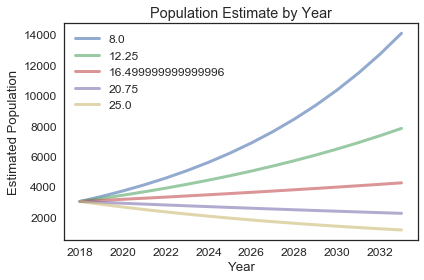

In [56]:
#Use for loop to run through the simulation using different values as the death rate
for i in range(0, 5):
    #plot the results of each simulation on a graph showing the next 15 years
    plot(run_simulation(system, update_func, drArray[i]), label = drArray[i] * 100)
    decorate(xlabel = 'Year',
        ylabel = 'Estimated Population',
        title = 'Population Estimate by Year')

Per the results of the graph, we are shown that the a death rate of roughly 16.5% shows the first upward trend in moose population for the rates we tested.  However, we can make the assumption that the death rate could be slightly less than 16% and still yield a upward trend in moose population.  Due to this, to save the moose population in Northeastern Minnesota, we need to reduce the death rate of the moose to ~16% in the coming years.  Although this model does not provide an explicit plan of action, a reduced death rate would alleviate the risk of moose going extinct in Northeastern Minnesota - as shown through this model.  To account for all the death rate factors, many parameters would have been needed.  However, two of the largest factors are ticks and wolves, which are difficult to model due to their variation year to year.  Thus, these are a critical aspect to consider when minimizing moose death rate. 